In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms

df = pd.read_csv("data.txt", sep="|")
df.head()
# By inspection of data.txt, the only NAs occur for inflation and interest in 1950 Q1
# data.txt includes complete quarterly data from 1950 Q1 to 2000 Q4 
# with all dates in order and with no missing quarters

,date,gdp,consumption,invest,government,dpi,cpi,m1,tbill,unemp,population,inflation,interest
0,1950 Q1,1610.5,1058.9,198.1,361.0,1186.1,70.6,110.20,1.12,6.4,149.461,NaN,NaN
1,1950 Q2,1658.8,1075.9,220.4,366.4,1178.1,71.4,111.75,1.17,5.6,150.260,4.5071,-3.3404
2,1950 Q3,1723.0,1131.0,239.7,359.6,1196.5,73.2,112.95,1.23,4.6,151.064,9.9590,-8.7290
3,1950 Q4,1753.9,1097.6,271.8,382.5,1210.0,74.9,113.93,1.35,4.2,151.871,9.1834,-7.8301
4,1951 Q1,1773.5,1122.8,242.9,421.9,1207.9,77.3,115.08,1.40,3.5,152.393,12.6160,-11.2160


In [2]:
# Only consumption, dpi and unemp are required for this analysis
# The rest can be dropped, including date labels
# Regression is to be performed on differences of the macroeconomic data values
dconsum = (df.consumption.diff())[1:]  # diffs with leading NaNs removed
ddpi = (df.dpi.diff())[1:]
dunemp = (df.unemp.diff())[1:]

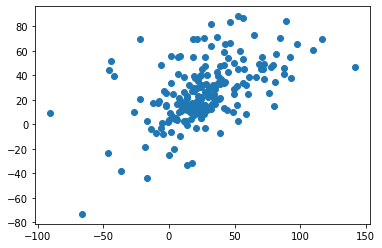

In [3]:
# Visualize consumption vs dpi
fig, ax = plt.subplots()
ax.scatter(ddpi, dconsum)
plt.show()
# A positive correlation is observed

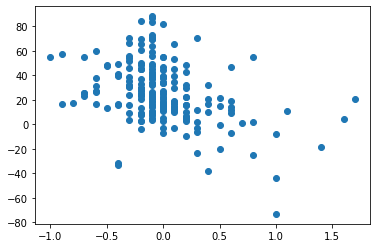

In [4]:
# Visualize consumption vs unemployment
fig, ax = plt.subplots()
ax.scatter(dunemp, dconsum)
plt.show()
# A slight negative correlation can be inferred

In [5]:
# Task 1: Replication of Results 
y = pd.DataFrame(dconsum)
X = pd.DataFrame(ddpi)
X['unemp'] = dunemp


In [6]:
# Set up regression inputs for statsmodels.api
X = sm.add_constant(X)  # Add an intercept (beta_0) to the model
model = sm.OLS(y, X).fit()

# Print out the statistics
model.summary()

# Note that regression coefficients, standard errors, t-statistics, and p-values 
# match given values from the coding exercise.
# The R-squared result of 33.5% does not indicate an accurate regression.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            consumption   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     50.31
Date:                Sun, 17 Jul 2022   Prob (F-statistic):           2.00e-18
Time:                        18:11:33   Log-Likelihood:                -898.12
No. Observations:                 203   AIC:                             1802.
Df Residuals:                     200   BIC:                             1812.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.2848      1.911      8.522      0.000      12.517      20.053
dpi            0.3557      0.048      7.444      0.000       0.261       0.450
unemp        -16.0149      3.792     -4.223      0.000     -23.493      -8.537
==============================================================================
Omnibus:                       12.022   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.257
Skew:                           0.459   Prob(JB):                     0.000802
Kurtosis:                       3.919   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# Conclusions for Task 1: 
# Results of the regression estimation using own implementations verified.
# Small p values indicate statistic significance for dpi and unemp independent variables
# Regression accuracy evaluation: Accuracy is low as indicated by the 33.5% R-squared

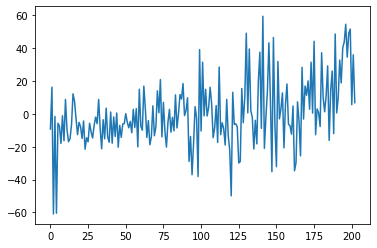

In [8]:
# Task 2: Outlier Detections
# Examine the time series of residuals
actuals = np.array(y).ravel()               # actuals as numpy array
predictions = np.array( model.predict(X) )  # model predictions as numpy array
residuals = (actuals - predictions)

# Plot the residuals time series
fig, ax = plt.subplots()
ax.plot(residuals)
plt.show()

In [9]:
# Use Tukeys test
Q1 = np.percentile(residuals, 25, interpolation = 'midpoint')  # First quartile (Q1)
Q2 = np.percentile(residuals, 50, interpolation = 'midpoint')  # Median (Q2)
Q3 = np.percentile(residuals, 75, interpolation = 'midpoint')  # Third quartile (Q3)
IQR = Q3 - Q1  # Interquaritle range (IQR)
Tlower = Q1 - 1.5*IQR  # Tukey lower bound
Tupper = Q3 + 1.5*IQR  # Tukey upper bound
print(Q1, Q2, Q3, IQR, Tlower, Tupper)

-12.660227921785275 -3.0649453317164763 9.736544273737909 22.396772195523184 -46.25538621507005 43.33170256702269


In [10]:
# Counts of outliers
r = np.array(residuals)  # Use numpy array for count functionality
l = np.count_nonzero(r < Tlower)  # Count of lower outliers
u = np.count_nonzero(r > Tupper)  # Count of upper outliers
n = len(r)  # number of elements in the dataset
print(l, u, n)

3 9 203


In [11]:
# Conclusions for Task 2
# There are 12 outliers in the dataset with 203 elements, representing 6% of the data
# This number of outliers is quite high.
# There are 3x outliers on the upper side vs lower: 9 upper vs 3 lower.
# Observing the residual timeseries plot above, 
# the upper outliers happen in the later half of the time series.

# This pattern of outliers, and the chart iteself, indicate a non-uniform variance of residuals, 
# which is otherwise known as heteroscedasticity.
# According to Wikipedia, the implications for the interpretation of the regression results are:
# "Assuming a variable is homoscedastic when in reality it is heteroscedastic results in unbiased 
# but inefficient point estimates and in biased estimates of standard errors, 
# and may result in overestimating the goodness of fit as measured by the Pearson coefficient."

# One cause of the heteroscedasticity is that consumption and dpi figures increase exponentially 
# over the 50 year period, and so differences between quarters grow over time.
# It may be more appropriate to do the analysis with log returns or percent changes
# rather than differences, in order to remove this issue.

# And indeed, when the same data is fitted with percent changes instead of differences,
# no outliers are observed in the later half of the data (refer to regrets.ipynb).
# R squared for the percent change data at 29.1% is lower than the 33.5% for difference data,
# so the goodness of fit also appears to have been over-estimated due to heteroscedasticity.

In [12]:
# Test 3: Autocorrelation of Residuals
# Calculate the Durbin-Watson (DW) statistic of the residuals
# Verify Durbin-Watson value of 1.767 from the statsmodels summary above.

# Quarterly differences of residuals
dresiduals = (pd.DataFrame(residuals).diff())[1:]

ssd = (dresiduals**2).sum()  # Sum of squares of residual differences
ssr = (residuals**2).sum()   # Sum of the squared residuals

# DW statistic
DW = float( ssd / ssr )
print(DW)

1.767096373144141


In [13]:
# Conclusions for Test 3
# The statsmodels DW figure was verified by the above calculation
# The value of 1.767 is below 2, which indicates positive autocorrelation.
# However, values between 1.5 and 2.5 are considered acceptable.
# Therefore, autocorrelation in the residuals does not lead to significant
# undervaluation of the standard error in this analysis.

In [14]:
# Task 4: Bootstapping of Standard Errors
# Recalculate the standard errors of the regression coefficients using bootstrapping.
# Note that statsmodels standard errors of coefficients are given by model.bse
# The default coefficient standard errors are given by:
se_dpi_def = model.bse['dpi']
se_unemp_def = model.bse['unemp']
print(se_dpi_def, se_unemp_def)
# As expected, these are the same figures shown in the statsmodels summary table

0.04777901318993685 3.7921569070723877


In [15]:
# Generate bootstrap samples and calculate standard errors of the coefficients
from sklearn.utils import resample
n_bootstraps = 10000

# initialire output arrays
se_dpi = []    # standard error of the dpi coefficient
se_unemp = []  # standard error of the unemployment coefficient

for _ in range(n_bootstraps):
    ys, Xs = resample(y, X, replace=True)
    bmodel = sm.OLS(ys, Xs).fit()
    
    # Append standard errors to output arrays
    se_dpi.append( bmodel.bse['dpi'] )       
    se_unemp.append( bmodel.bse['unemp'] )   
    
se_dpi = np.array(se_dpi)      # Use numpy array for stats functionality
se_unemp = np.array(se_unemp)  

In [16]:
# Compare the bootstrapped standard errors to the default standard errors. 
# What differences can be observed? What are the implications?

# According to Michael Grogan, https://medium.com/p/b112bb4a969e, "a primary use of 
# bootstrapping is to estimate the confidence interval of the population mean."
# Statsmodels documentation provides the following for calculating the 95th confidence interval
# sms.DescrStatsW(samples).tconfint_mean()

0.04777901318993685 0.047919462143011494 0.04800832278593042 0.04809718342884934


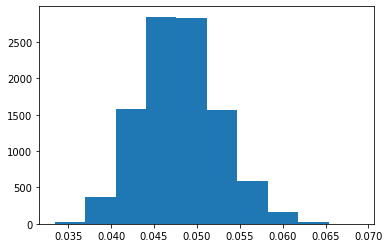

In [17]:
# DPI coefficient - Summary and histogram of bootstrapped standard errors 

def_se = se_dpi_def      # default standard error from the original regression
mean_se = se_dpi.mean()  # mean of bootstrapped standard errors
lconf, uconf = sms.DescrStatsW(se_dpi).tconfint_mean()  #lower and upper confidence levels

# Print the default, lower confidence level, mean and upper confidence level
print(def_se, lconf, mean_se, uconf)

# Histogram the bootstrapped standard errors
fig, ax = plt.subplots()
ax.hist(se_dpi)
plt.show()

3.7921569070723877 3.8076106306306285 3.8148457307102857 3.8220808307899428


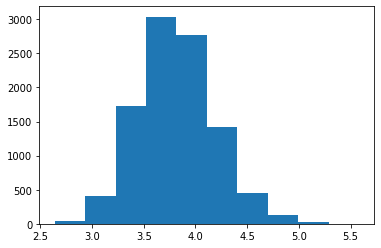

In [18]:
# Unemployment coefficient - Summary and histogram of bootstrapped standard errors 

def_se = se_unemp_def      # default standard error from the original regression
mean_se = se_unemp.mean()  # mean of bootstrapped standard errors
lconf, uconf = sms.DescrStatsW(se_unemp).tconfint_mean()

# Print the default, lower confidence level, mean and upper confidence level
print(def_se, lconf, mean_se, uconf)

# Histogram the bootstrapped standard errors
fig, ax = plt.subplots()
ax.hist(se_unemp)
plt.show()

In [19]:
# Conclusions for Task 4

# According to the Central Limit theorem, these distributions are expected to tend to normals
# as the sample size increases, and indeed these distributions appear normal.

# For both DPI and Unemployment, the default coefficient standard errors are smaller than 
# the means of the bootstapped standard errors, and even fall below the 95th confidence
# intervals for these measures.  

# This result is not surprising, given the heteroscedasticity identified in Task 2,
# where one of the stated implications is biased estimates of standard errors.

# Further support to this conclusion may be given by performing the same bootstrap on the percent change
# data in regrets.ipynb.  The result in this case is that the default DPI coefficient standard error 
# does indeed fall within the 95th confidence interval, but the default unemployment standard error
# remains outside of the bootstap determined confidence interval.